# Third Harmonic Generation

In this example, we consider wave propagation through a simple 1d nonlinear medium with a non-zero Kerr susceptibility $\chi^{(3)}$. See also [Materials](https://meep.readthedocs.io/en/latest/Materials/#nonlinearity) and [Units and Nonlinearity](https://meep.readthedocs.io/en/latest/Units_and_Nonlinearity/). We send in a narrow-band pulse at a frequency $\omega$, and because of the nonlinearity we also get a signal at a frequency $3\omega$.

Since this is a 1d calculation, we could implement it via a 2d cell of `Vector3(S,0,0)`, specifying periodic boundary conditions in the $y$ direction. However, this is slightly inefficient since the $y$ periodic boundaries are implemented internally via extra "ghost pixels" in the $y$ direction. Instead, Meep has special support for 1d simulations in the $z$ direction. To use this, we must explicitly set `dimensions` to 1 in the `Simulation` object constructor, and in that case we can only use $E_x$ (and $D_x$) and $H_y$ field components. This involves no loss of generality because of the symmetry of the problem.

We are going to fill the entire computational cell with the nonlinear medium, so we don't need to use any objects. We can just use the special `default_material` which is ordinarily vacuum. PMLs are placed at the $\pm 1$ boundaries. The source will be a Gaussian pulse of $J_x$ just next to the $-z$ PML layer. Since this is a nonlinear calculation, we may want to play with the amplitude of the current/field, so we set the `amplitude` property explicitly to a parameter `amp`.

In [1]:
from typing import Tuple, List, Union
import numpy as np
from matplotlib import pyplot as plt
import meep as mp
%matplotlib notebook

Using MPI version 3.1, 1 processes


Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
def third_harmonic_generation(
    k: float, amp: float = 1.0, nfreq: int = 10, flux_spectrum: bool = True
) -> Union[Tuple[List[float], List[float]], Tuple[float, float]]:
    
    """Computes the transmission spectrum of a plane wave propagating                                             
       through a Kerr medium.                                                                                     
                                                                                                                  
    Args:                                                                                                         
      k: strength of Kerr susceptibility.                                                                         
      amp: amplitude of the incident planewave.                                                                   
      nfreq: number of frequencies in flux spectrum.                                                              
      flux_spectrum: compute the flux spectrum over broad bandwidth (True) or                                     
                     just the two harmonic frequencies ω and 3ω (False).                                          
                                                                                                                  
    Returns:                                                                                                      
      The frequencies and transmitted flux over the flux spectrum or                                              
      the transmitted flux at the harmonic frequencies ω and 3ω.                                                  
    """
    
    sz = 100  # size of cell in z direction                                                                       
    fcen = 1 / 3.0  # center frequency of source                                                                  
    df = fcen / 20.0  # frequency width of source                                                                 
    dpml = 1.0  # PML thickness                                                                                   

    # We'll use an explicitly 1d simulation.  Setting dimensions=1 will actually                                  
    # result in faster execution than just using two no-size dimensions.  However,                                
    # in this case Meep requires us to use E in the x direction (and H in y),                                     
    # and our one no-size dimension must be z.                                                                    
    dimensions = 1
    cell = mp.Vector3(0, 0, sz)
    pml_layers = [mp.PML(dpml)]
    resolution = 25

    # to put the same material in all space, we can just set the default material                                 
    # and pass it to the Simulation constructor                                                                   
    default_material = mp.Medium(index=1, chi3=k)

    sources = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ex,
            center=mp.Vector3(0, 0, -0.5 * sz + dpml),
            amplitude=amp,
        )
    ]

    # frequency range for flux calculation                                                                        
    fmin = fcen / 2.0
    fmax = fcen * 4

    sim = mp.Simulation(
        cell_size=cell,
        sources=sources,
        boundary_layers=pml_layers,
        default_material=default_material,
        resolution=resolution,
        dimensions=dimensions,
    )

    mon_pt = mp.Vector3(0, 0, 0.5 * sz - dpml - 0.5)
    
    if flux_spectrum:
        trans = sim.add_flux(
            0.5 * (fmin + fmax),
            fmax - fmin,
            nfreq,
            mp.FluxRegion(mon_pt),
            decimation_factor=1,
        )
    else:
        trans1 = sim.add_flux(fcen, 0, 1, mp.FluxRegion(mon_pt), decimation_factor=1)
        trans3 = sim.add_flux(
            3 * fcen, 0, 1, mp.FluxRegion(mon_pt), decimation_factor=1
        )

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mon_pt, 1e-6))

    if flux_spectrum:
        freqs = mp.get_flux_freqs(trans)
        trans_flux = mp.get_fluxes(trans)
        return freqs, trans_flux
    else:
        print(
            f"harmonics:, {k}, {amp}, {mp.get_fluxes(trans1)[0]}, "
            f"{mp.get_fluxes(trans3)[0]}"
        )
        return mp.get_fluxes(trans1)[0], mp.get_fluxes(trans3)[0]

Note that we must turn off DFT decimation by passing an additional argument of `decimation_factor=1` to the `add_flux` monitor definitions because decimation is on by default.

In the first part of this tutorial, we plot the transmitted power spectrum for various values of $\chi^{(3)}$. In a linear problem, we normally look at the spectrum over the same frequency range as our source, because other frequencies are zero. In this case, however, we will look from `fcen/2` to `4*fcen`, to be sure that we can see the third-harmonic frequency.

In [3]:
nfreq = 400
logk = range(-3, 1)
tflux = np.zeros((nfreq, len(logk)))
for i, lk in enumerate(logk):
    freqs, tflux[:, i] = third_harmonic_generation(
        10**lk, nfreq=nfreq, flux_spectrum=True
    )

-----------
Initializing structure...
time for choose_chunkdivision = 9.729e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 100 with resolution 25
time for set_epsilon = 0.00084729 s
-----------
field decay(t = 100.04): 5.345069974777698e-12 / 5.345069974777698e-12 = 1.0
field decay(t = 150.06): 1.0169446296713276e-08 / 1.0169446296713276e-08 = 1.0
field decay(t = 200.08): 4.650911893321058e-06 / 4.650911893321058e-06 = 1.0
field decay(t = 250.1): 0.0005451205008237801 / 0.0005451205008237801 = 1.0
field decay(t = 300.12): 0.01777078053576906 / 0.01777078053576906 = 1.0
field decay(t = 350.14): 0.13039636481724018 / 0.13039636481724018 = 1.0
field decay(t = 400.16): 0.24555052973214989 / 0.24555052973214989 = 1.0
field decay(t = 450.18): 0.24496560125506897 / 0.24555052973214989 = 0.9976178895736085
field decay(t = 500.2): 0.11044114777393739 / 0.24555052973214989 = 0.4497695358035196
field decay(t = 550.22): 0.012780456545355666 / 0.24555052973214989 = 0.0520481733812457

<IPython.core.display.Javascript object>


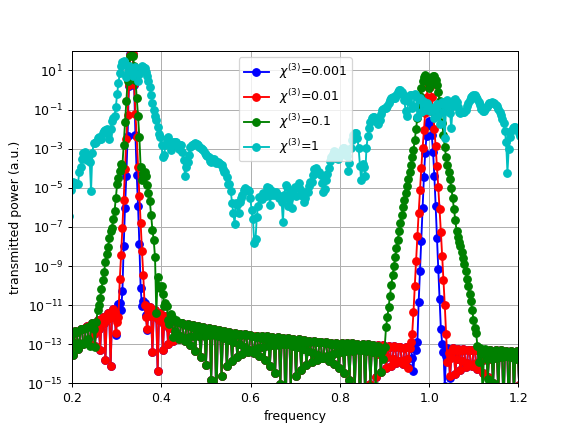

/home/oskooi/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/oskooi/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [4]:
fig, ax = plt.subplots()
ax.semilogy(freqs, tflux[:, 0], "bo-", label=r"$\chi^{(3)}$=0.001")
ax.semilogy(freqs, tflux[:, 1], "ro-", label=r"$\chi^{(3)}$=0.01")
ax.semilogy(freqs, tflux[:, 2], "go-", label=r"$\chi^{(3)}$=0.1")
ax.semilogy(freqs, tflux[:, 3], "co-", label=r"$\chi^{(3)}$=1")
ax.set_xlabel("frequency")
ax.set_ylabel("transmitted power (a.u.)")
ax.set_xlim(0.2, 1.2)
ax.set_ylim(1e-15, 1e2)
ax.legend()
ax.grid(True)
plt.show()

For small values of $\chi^{(3)}$, we see a peak from our source at $\omega=\frac{1}{3}$ and another peak 
precisely at the third-harmonic frequency $3\omega=1$. As the $\chi^{(3)}$ gets larger, frequency-mixing 
*within* the peaks causes them to broaden, and finally for $\chi^{(3)}=1$ we start to see a noisy, broad-spectrum 
transmission due to the phenomenon of **modulation instability**. Notice also that at around $10^{-13}$ the 
data looks weird; this is probably due to our finite simulation time, imperfect absorbing boundaries, etcetera. 
We haven't attempted to analyze it in detail for this case.

In the second part of the tutorial, we investigate the dependence of the power at $\omega$ and $3\omega$ as a  function of $\chi^{(3)}$ and the current amplitude. We could, of course, interpolate the flux spectrum above to get the desired frequencies, but it is easier just to add two flux regions to Meep and request exactly the desired frequency components.

In [5]:
logk = np.arange(-6.0, 0.2, 0.2)
first_order = np.zeros(len(logk))
third_order = np.zeros(len(logk))
for i, lk in enumerate(logk):
    first_order[i], third_order[i] = third_harmonic_generation(
        10**lk, flux_spectrum=False
    )

-----------
Initializing structure...
time for choose_chunkdivision = 7.5132e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 100 with resolution 25
time for set_epsilon = 0.000512927 s
-----------
field decay(t = 100.04): 5.345069974778501e-12 / 5.345069974778501e-12 = 1.0
field decay(t = 150.06): 1.0169446304565756e-08 / 1.0169446304565756e-08 = 1.0
field decay(t = 200.08): 4.6509134041875294e-06 / 4.6509134041875294e-06 = 1.0
field decay(t = 250.1): 0.0005451393864268183 / 0.0005451393864268183 = 1.0
field decay(t = 300.12): 0.01779607955736104 / 0.01779607955736104 = 1.0
field decay(t = 350.14): 0.13167020369297935 / 0.13167020369297935 = 1.0
field decay(t = 400.16): 0.24987915109109593 / 0.24987915109109593 = 1.0
field decay(t = 450.18): 0.2492659288871275 / 0.24987915109109593 = 0.9975459248949311
field decay(t = 500.2): 0.11135321997058951 / 0.24987915109109593 = 0.44562829465510145
field decay(t = 550.22): 0.012792973351210858 / 0.24987915109109593 = 0.051196641637

field decay(t = 700.28): 4.467112777638655e-09 / 0.24984153835108858 = 1.787978415086953e-08
run 0 finished at t = 700.28 (35014 timesteps)
harmonics:, 1.0000000000000021e-05, 1.0, 225.16434484850555, 2.515516990517998e-06
-----------
Initializing structure...
time for choose_chunkdivision = 7.1334e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 100 with resolution 25
time for set_epsilon = 0.00129906 s
-----------
field decay(t = 100.04): 5.345069974778606e-12 / 5.345069974778606e-12 = 1.0
field decay(t = 150.06): 1.0169446304449148e-08 / 1.0169446304449148e-08 = 1.0
field decay(t = 200.08): 4.650913381730357e-06 / 4.650913381730357e-06 = 1.0
field decay(t = 250.1): 0.000545139105831829 / 0.000545139105831829 = 1.0
field decay(t = 300.12): 0.017795707145032064 / 0.017795707145032064 = 1.0
field decay(t = 350.14): 0.13165139755400873 / 0.13165139755400873 = 1.0
field decay(t = 400.16): 0.24981702876003392 / 0.24981702876003392 = 1.0
field decay(t = 450.18): 0.249204469141

field decay(t = 650.26): 2.403013284453902e-06 / 0.24920348319619115 = 9.642775669239241e-06
field decay(t = 700.28): 4.467090445070018e-09 / 0.24920348319619115 = 1.792547354385572e-08
run 0 finished at t = 700.28 (35014 timesteps)
harmonics:, 0.00015848931924611207, 1.0, 225.16179312916677, 0.0006310268008721403
-----------
Initializing structure...
time for choose_chunkdivision = 7.1737e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 100 with resolution 25
time for set_epsilon = 0.000479143 s
-----------
field decay(t = 100.04): 5.345069974778269e-12 / 5.345069974778269e-12 = 1.0
field decay(t = 150.06): 1.0169446302599233e-08 / 1.0169446302599233e-08 = 1.0
field decay(t = 200.08): 4.650913025808378e-06 / 4.650913025808378e-06 = 1.0
field decay(t = 250.1): 0.0005451346582304672 / 0.0005451346582304672 = 1.0
field decay(t = 300.12): 0.017789790117491676 / 0.017789790117491676 = 1.0
field decay(t = 350.14): 0.1313471646264031 / 0.1313471646264031 = 1.0
field decay(t = 40

field decay(t = 550.22): 0.012761153864268465 / 0.24009442281853152 = 0.05315056349273726
field decay(t = 600.24): 0.00037672517750389907 / 0.24009442281853152 = 0.0015690709225204952
field decay(t = 650.26): 2.4030109102183914e-06 / 0.24009442281853152 = 1.0008607788589234e-05
field decay(t = 700.28): 4.467285139279417e-09 / 0.24009442281853152 = 1.8606367806618675e-08
run 0 finished at t = 700.28 (35014 timesteps)
harmonics:, 0.0025118864315095977, 1.0, 224.87354381468265, 0.1541822732049199
-----------
Initializing structure...
time for choose_chunkdivision = 7.3537e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 100 with resolution 25
time for set_epsilon = 0.000906163 s
-----------
field decay(t = 100.04): 5.345069974775395e-12 / 5.345069974775395e-12 = 1.0
field decay(t = 150.06): 1.0169446273280971e-08 / 1.0169446273280971e-08 = 1.0
field decay(t = 200.08): 4.650907384754755e-06 / 4.650907384754755e-06 = 1.0
field decay(t = 250.1): 0.0005450640504066537 / 0.0005450

field decay(t = 550.22): 0.012365563019300866 / 0.20820740580453972 = 0.05939060126857048
field decay(t = 600.24): 0.0003763526195198078 / 0.20820740580453972 = 0.0018075851724175405
field decay(t = 650.26): 2.4029889551311664e-06 / 0.20820740580453972 = 1.154132316209269e-05
field decay(t = 700.28): 4.467162646732303e-09 / 0.20820740580453972 = 2.145534943615777e-08
run 0 finished at t = 700.28 (35014 timesteps)
harmonics:, 0.0398107170553501, 1.0, 193.6011512723667, 10.070607189474567
-----------
Initializing structure...
time for choose_chunkdivision = 7.1003e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 100 with resolution 25
time for set_epsilon = 0.000478839 s
-----------
field decay(t = 100.04): 5.345069974729155e-12 / 5.345069974729155e-12 = 1.0
field decay(t = 150.06): 1.0169445808617165e-08 / 1.0169445808617165e-08 = 1.0
field decay(t = 200.08): 4.650817962461843e-06 / 4.650817962461843e-06 = 1.0
field decay(t = 250.1): 0.0005439156829478632 / 0.00054391568294

field decay(t = 500.2): 0.12912188463630342 / 0.21391676622793007 = 0.6036080617389429
field decay(t = 550.22): 0.011642738890991022 / 0.21391676622793007 = 0.05442649071548505
field decay(t = 600.24): 0.0003704269461133881 / 0.21391676622793007 = 0.0017316405471401672
field decay(t = 650.26): 2.407408397879035e-06 / 0.21391676622793007 = 1.1253949095854981e-05
field decay(t = 700.28): 4.514705562622321e-09 / 0.21391676622793007 = 2.110496359042687e-08
run 0 finished at t = 700.28 (35014 timesteps)
harmonics:, 0.6309573444802007, 1.0, 22.671433283101095, 0.35168002847340085
-----------
Initializing structure...
time for choose_chunkdivision = 7.4407e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 100 with resolution 25
time for set_epsilon = 0.00127866 s
-----------
field decay(t = 100.04): 5.34506997399672e-12 / 5.34506997399672e-12 = 1.0
field decay(t = 150.06): 1.016943844414871e-08 / 1.016943844414871e-08 = 1.0
field decay(t = 200.08): 4.649396296768605e-06 / 4.649396

We divide the transmitted power at all values of $\chi^{(3)}$ by the transmitted power at $\omega$ for the smallest $\chi^{(3)}$ of $10^{-6}$ which is 225.25726603587043. We then plot the fractional transmission at $\omega$ and $3\omega$ as a function of $\chi^{(3)}$ on a log-log scale.

<IPython.core.display.Javascript object>


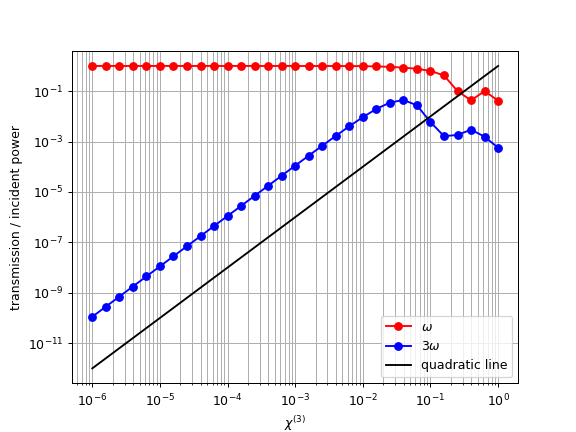

In [6]:
input_flux = first_order[0]
fig, ax = plt.subplots()
ax.loglog(10**logk, first_order / input_flux, "ro-", label=r"$\omega$")
ax.loglog(10**logk, third_order / input_flux, "bo-", label=r"$3\omega$")
ax.loglog(10**logk, (10**logk) ** 2, "k-", label="quadratic line")
ax.set_xlabel(r"$\chi^{(3)}$")
ax.set_ylabel("transmission / incident power")
ax.legend()
ax.grid(True,'both')
plt.show()

As can be shown from coupled-mode theory or, equivalently, follows from [Fermi's golden rule](https://en.wikipedia.org/wiki/Fermi's_golden_rule), the third-harmonic power must go as the *square* of $\chi^{(3)}$ as long as the nonlinearity is weak (i.e. in the first Born approximation limit, where the $\omega$ source is not depleted significantly). This is precisely what we see on the above graph, where the slope of the black line indicates an exact quadratic dependence, for comparison. Once the nonlinearity gets strong enough, however, this approximation is no longer valid and the dependence is complicated.

Finally, we note that increasing the current amplitude by a factor of $F$ or the Kerr susceptibility $\chi^{(3)}$ by a factor $F^3$ should generate the *same* third-harmonic power in the *weak* nonlinearity approximation. And indeed, we see:

```
harmonics:, 0.001, 1.0, 225.2091048223644, 0.021498041565849526
```

```
harmonics:, 1e-06, 10.0, 22525.588597389557, 0.021791784143189268
```

which have third-harmonic powers differing by about 1% (last column).